# Reinforcement learning for Text-Flappy-Bird environment
RL Assignment, Mention SDI, 3A, CentraleSupélec

Léo Buecher

Git repository : https://github.com/leobcairo/RL_Assignment_code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium
import text_flappy_bird_gym
# import time
# import os, sys
# from tqdm import tqdm

In [2]:
env = gymnasium.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

# Agents

## Base agent class

In [3]:
class BaseAgent:
    def __init__(self, observation_space, num_actions, epsilon, step_size, discount, seed):
        """Setup for the agent called when the experiment first starts.
        
        Args:
            observation_space (gymnasium.spaces.tuple.Tuple) : Describes the observation space. Contains 2 object of type gymnasium.spaces.discrete.Discrete
            num_actions (int): The number of actions,
            epsilon (float)  : The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float) : The discount factor,
            seed (int)       : Seed used for random sampling
        """
        # Fixed attributes
        self.nx, self.start_x, self.ny, self.start_y = self.read_obs_space(observation_space)
        self.num_states     = self.nx*self.ny
        self.num_actions    = num_actions
        self.epsilon_init   = epsilon
        self.step_size      = step_size
        self.discount       = discount
        # self.seed           = seed
        self.rand_generator = np.random.RandomState(seed)
        
        # Evolving attributes
        self.epsilon        = epsilon
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

    def read_obs_space(self, observation_space):
        """Method called once, to analyse the observation space

        Args:
            observation_space (gymnasium.spaces.tuple.Tuple): The observation space object get from the environment. Expected to be a Tuple of Discrete objects.

        Returns:
            nx, start_x, ny, start_y (tuple(int, int, int, int)): The number of discrete states in the x and y directions, and the integer they start from.
        """
        x_space = observation_space[0]
        nx = x_space.n
        start_x = x_space.start

        y_space = observation_space[1]
        ny = y_space.n + 2 # There is sth strange with the environment
        start_y = y_space.start - 1
        return nx, start_x, ny, start_y
    
    def convert_state(self, state):
        """Converts the state as tuple to an integer that can be used in self.q
        Args:
            state (tuple(int, int)): State obtained from the environment
        Returns:
            int: Converted state
        """
        assert self.start_x <= state[0] < self.start_x + self.nx, f"Abscissa {state[0]} is not legal"
        assert self.start_y <= state[1] < self.start_y + self.ny, f"Ordinate {state[1]} is not legal"
        return (state[0] - self.start_x) + self.nx*(state[1] - self.start_y)

    def agent_start(self, state):
        """The first method called when the episode starts, called after the environment starts.
        Args:
            state (tuple): the state from the environment's env_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        action = self.epsilon_greedy_policy_sample(state)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (tuple): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        action = self.epsilon_greedy_policy_sample(state)
        
        # Some update
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates the episode.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Some update
        pass
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)
    
    def epsilon_greedy_policy_sample(self, state):
        """Samples an action for a given state using the epsilon greedy policy.

        Args:
            state (tuple): state as received from the environment object

        Returns:
            int: action
        """
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(self.q[self.convert_state(state),:]) # greedy action selection
        return action
    
    def epsilon_greedy_policy_probs(self, state):
        """ obtains the action probabilities corresponding to epsilon-greedy policy """
        state_int = self.convert_state(state)
        policy_s = np.ones((self.num_actions))*self.epsilon/self.num_actions
        best_a = np.argmax(self.q[state_int, :])
        policy_s[best_a] += 1 - self.epsilon
        return policy_s

    def get_state_value_function(self):
        """Returns the state value function under a rectangular shape (like the state space)

        Returns:
            vf_reshaped (np.array of dim 2): vf_reshaped[dy+12, dx] correspond to v((dx, dy))
        """
        # expectation of q, using the espilon greedy policy
        vf = self.q.sum(axis=1)*self.epsilon/self.num_actions
        vf += self.q.max(axis=1)*(1 - self.epsilon)
        
        vf_reshaped = np.reshape(vf, (self.ny, self.nx)) #columns correspond to dx, rows correspond to dy + 12
        # vf_reshaped = vf_reshaped[:,::-1] #to put small dx on the right (like on the screen)
        return vf_reshaped


    def update_epsilon(self, *args):
        """Updates epsilon
        """
        pass

    def reset(self, seed=None):
        """Forget everything the agent has learnt.
        To use at the beginning of a run
        """
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.
        self.epsilon = self.epsilon_init
        if not(seed is None):
            self.rand_generator = np.random.RandomState(seed)

## Monte-Carlo Control

In [4]:
class MonteCarloAgent(BaseAgent):
    """From Sutton and Barto's book, p. 97, 
    but considering every couple (s, a) visited in an episode (not just the first one).
    """
    def __init__(self, observation_space, num_actions, epsilon, step_size, discount, seed, eps_law = 0):
        # Step size is not used
        super().__init__(observation_space, num_actions, epsilon, step_size, discount, seed)
        self.eps_law = eps_law
        self.hist_states  = []
        self.hist_rewards = []
        self.hist_actions = []

        self.n_visits = np.zeros((self.num_states, self.num_actions), dtype=int)
    
    def agent_start(self, state):
        """The first method called when the episode starts, called after the environment starts.
        Args:
            state (tuple): the state from the environment's env_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        action = super().agent_start(state)
        self.hist_states.append(state)
        self.hist_actions.append(action)
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (tuple): the state from the environment's step based on where the agent ended up after the last step.
        Returns:
            action (int): the action the agent is taking.
        """
        self.hist_states.append(state)
        self.hist_rewards.append(reward)

        action = self.epsilon_greedy_policy_sample(state)
        self.hist_actions.append(action)
        
        # self.prev_state = state
        # self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the terminal state.
        """
        self.hist_rewards.append(reward)

        T = len(self.hist_rewards)
        G = 0
        for t in range(T-1, -1, -1):
            G = self.discount*G + self.hist_rewards[t] #gamma*G + R_{t+1}
            state_int = self.convert_state(self.hist_states[t])
            action = self.hist_actions[t]
            self.n_visits[state_int, action] +=1
            self.q[state_int, action] += 1/self.n_visits[state_int, action]*(G - self.q[state_int, action])

        self.hist_actions = []
        self.hist_rewards = []
        self.hist_states  = []
    
    def update_epsilon(self, k):
        """Updates epsilon
        """
        self.epsilon = self.epsilon_init/(k+1)**self.eps_law
    
    def reset(self, seed=None):
        """Forget everything the agent has learnt.
        To use at the beginning of a run
        """
        super().reset(seed)
        self.n_visits = np.zeros((self.num_states, self.num_actions), dtype=int)
        self.hist_actions = [] #Not useful, but precaution
        self.hist_rewards = []
        self.hist_states  = []


## Expected Sarsa

In [5]:
class ExpectedSarsaAgent(BaseAgent):
    def __init__(self, observation_space, num_actions, epsilon, step_size, discount, seed, eps_law = 0):
        super().__init__(observation_space, num_actions, epsilon, step_size, discount, seed)
        self.eps_law = eps_law
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (tuple): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        action = self.epsilon_greedy_policy_sample(state)
        
        # Perform an update
        state_int = self.convert_state(state)
        current_q = self.q[state_int,:]

        s, a = self.prev_state, self.prev_action
        s_int = self.convert_state(s)
        
        pi = self.epsilon_greedy_policy_probs(state)
        self.q[s_int, a] += self.step_size*(reward + self.discount*pi.dot(current_q) - self.q[s_int, a])
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        s, a = self.prev_state, self.prev_action
        s_int = self.convert_state(s)
        self.q[s_int, a] += self.step_size*(reward - self.q[s_int, a])
    
    
    def update_epsilon(self, k):
        """Updates epsilon
        """
        self.epsilon = self.epsilon_init / (k+1)**self.eps_law


# Solving Flappy bird problem

## Functions to play the game and analyse it

In [6]:
def episode(env, ag: BaseAgent, *update_epsilon_args):
    """Runs an episode with the given environment and the given agent.

    Args:
        env (gymnasium environment): The environement.
        ag (BaseAgent): The agent.

    Returns:
        reward (int): Total reward
        hist_states (list of tuple): list of visited states
        hist_rewards (list of int): list of received rewards
        hist_actions (list of int): list of actions
    """
    hist_states  = []
    hist_rewards = []
    hist_actions = []

    state, _ = env.reset()     # ?
    action = ag.agent_start(state)
    hist_states.append(state)
    hist_actions.append(action)

    state, reward, done, _, info = env.step(action)

    while True:
        # Update epsilon if necessary. Here, it only changes after each episode
        ag.update_epsilon(*update_epsilon_args)

        # Sample action
        action = ag.agent_step(reward, state)

        # Save the state, the reward and the action
        hist_states.append(state)
        hist_rewards.append(reward)
        hist_actions.append(action)

        # Apply action and return new observation of the environment
        state, reward, done, _, info = env.step(action)

        # # Render the game
        # os.system("clear")
        # sys.stdout.write(env.render())
        # time.sleep(0.2) # FPS

        # If player is dead break
        if done:
            break

    hist_states.append(state)
    hist_rewards.append(reward)

    ag.agent_end(reward)
    env.close()
    return sum(hist_rewards), hist_states, hist_rewards, hist_actions

def run(env, ag: BaseAgent, num_episodes, seed=None):
    """Executes a certain number of episodes, along which the agent will learn.

    Args:
        env (gymnasium environment): The environment.
        ag (BaseAgent): The agent.
        num_episodes (int): The number of episodes
        seed (int, optional): The seed to reset the agent with. Defaults to None.

    Returns:
        list of int: List of rewards (one element per episode)
    """
    ag.reset(seed=seed)
    hist_ep_rewards = []
    for ep in range(num_episodes):
        ep_reward, _, _, _ = episode(env, ag, ep)
        hist_ep_rewards.append(ep_reward)
    return hist_ep_rewards

def sliding_mean(array, window_size):
    means = np.zeros((len(array)))
    for i in range(window_size - 1):
        means[i] = np.mean(array[:i+1])
    for i in range(window_size - 1, len(array)):
        means[i] = np.mean(array[i-window_size+1:i+1])
    return means

## Running Monte Carlo control

In [7]:
ag_mc = MonteCarloAgent(env.observation_space, num_actions=2, epsilon=0.04, step_size=0.5, discount= 0.95, seed=0)
ru_rewards_mc = run(env, ag_mc, 3000, 0)

200.83


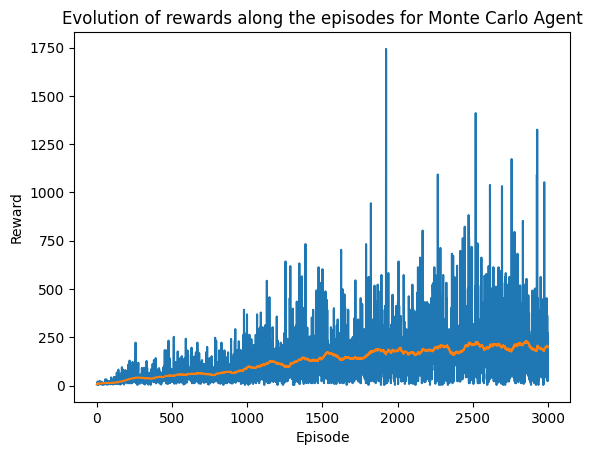

In [8]:
print(np.mean(ru_rewards_mc[-100:]))
plt.plot(ru_rewards_mc, label="Episodes rewards")
plt.plot(sliding_mean(ru_rewards_mc, 100), label="Sliding mean (window size=100)")
plt.title("Evolution of rewards along the episodes for Monte Carlo Agent")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

## Running Expected Sarsa

In [9]:
ag_sar = ExpectedSarsaAgent(env.observation_space, num_actions=2, epsilon=0.1, step_size=0.5, discount=0.95, seed=0)
ru_rewards_sarsa = run(env, ag_sar, 3000, 0)

99.14


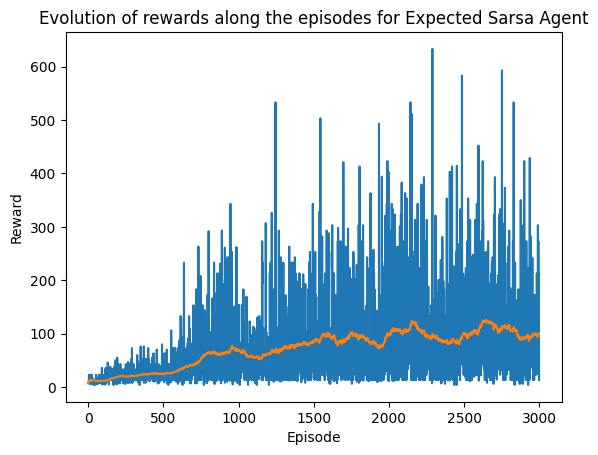

In [10]:
print(np.mean(ru_rewards_sarsa[-100:]))
plt.plot(ru_rewards_sarsa, label="Episodes rewards")
plt.plot(sliding_mean(ru_rewards_sarsa, 100), label="Sliding mean (window size=100)")
plt.title("Evolution of rewards along the episodes for Expected Sarsa Agent")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

# Hyperparameter search

## Epsilon for Monte Carlo

In [22]:
eps_init_list_mc = np.arange(0.01, 0.11, 0.01)
n_test = 10
mean_rw_eps_init_mc = np.zeros((len(eps_init_list_mc), n_test))
for i_eps, eps_init in enumerate(eps_init_list_mc):
    for k_test in range(n_test):
        agt = MonteCarloAgent(env.observation_space, num_actions=2, epsilon=eps_init, step_size=0.5, discount= 0.95, seed=i_eps*n_test + k_test)
        rewards_mc = run(env, agt, 1000, seed=i_eps*n_test + k_test)
        mean_rw_eps_init_mc[i_eps, k_test] = np.mean(rewards_mc[-200:])

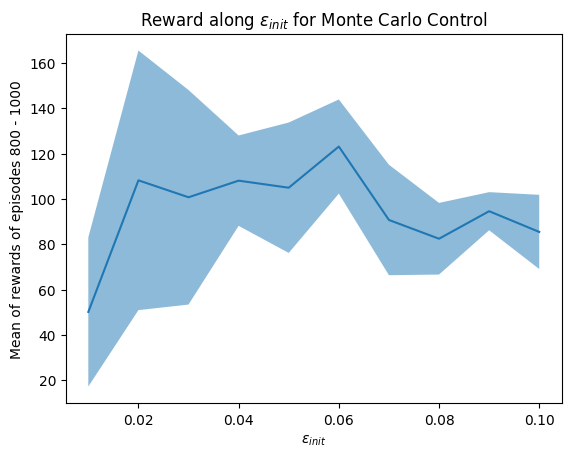

In [24]:
m = mean_rw_eps_init_mc.mean(axis=1)
s = mean_rw_eps_init_mc.std(axis=1)
plt.plot(eps_init_list_mc, m)
plt.fill_between(eps_init_list_mc, m - s, m + s, alpha=0.5)
plt.xlabel("$\\epsilon_{init}$")
plt.ylabel("Mean of rewards of episodes 800 - 1000")
plt.title("Reward along $\\epsilon_{init}$ for Monte Carlo Control")
plt.show()

In [33]:
eps_law_list_mc = np.arange(0., 1.1, 0.1)
n_test = 10
mean_rw_eps_law_mc = np.zeros((len(eps_law_list_mc), n_test))
for i_eps, eps_law in enumerate(eps_law_list_mc):
    for k_test in range(n_test):
        agt = MonteCarloAgent(env.observation_space, num_actions=2, epsilon=0.04, step_size=0.5, discount= 0.95, seed=i_eps*n_test + k_test, eps_law=eps_law)
        rewards_mc = run(env, agt, 1000, seed=i_eps*n_test + k_test)
        mean_rw_eps_law_mc[i_eps, k_test] = np.mean(rewards_mc[-200:])

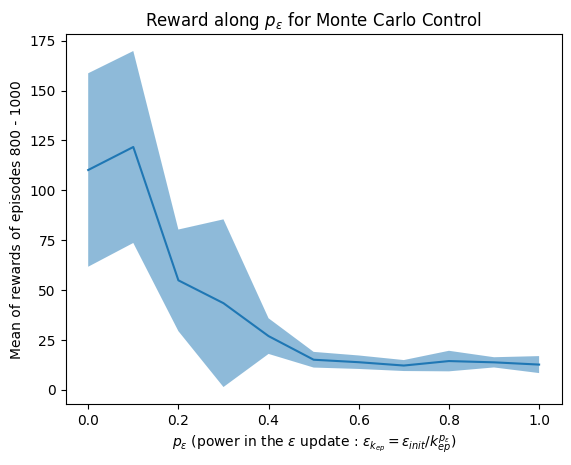

In [34]:
m = mean_rw_eps_law_mc.mean(axis=1)
s = mean_rw_eps_law_mc.std(axis=1)
plt.plot(eps_law_list_mc, m)
plt.fill_between(eps_law_list_mc, m - s, m + s, alpha=0.5)
plt.xlabel("$p_\\epsilon$ (power in the $\\epsilon$ update : $\\epsilon_{k_{ep}} = \\epsilon_{init}/k_{ep}^{p_\\epsilon}$)")
plt.ylabel("Mean of rewards of episodes 800 - 1000")
plt.title("Reward along $p_\\epsilon$ for Monte Carlo Control")
plt.show()

## Epsilon for Expected Sarsa

In [ ]:
eps_init_list_sarsa = np.arange(0.01, 0.16, 0.01)
n_test = 10
mean_rw_eps_init_sarsa = np.zeros((len(eps_init_list_sarsa), n_test))
for i_eps, eps_init in enumerate(eps_init_list_sarsa):
    for k_test in range(n_test):
        agt = ExpectedSarsaAgent(env.observation_space, num_actions=2, epsilon=eps_init, step_size=0.5, discount= 0.95, seed=i_eps*n_test + k_test)
        rewards_mc = run(env, agt, 1000, seed=i_eps*n_test + k_test)
        mean_rw_eps_init_sarsa[i_eps, k_test] = np.mean(rewards_mc[-200:])

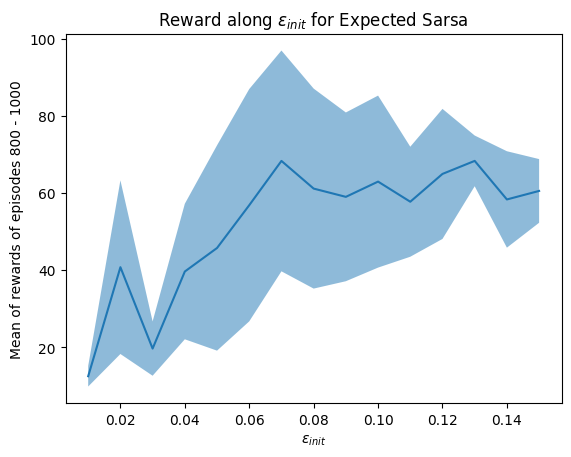

In [29]:
m = mean_rw_eps_init_sarsa.mean(axis=1)
s = mean_rw_eps_init_sarsa.std(axis=1)
plt.plot(eps_init_list_sarsa, m)
plt.fill_between(eps_init_list_sarsa, m - s, m + s, alpha=0.5)
plt.xlabel("$\\epsilon_{init}$")
plt.ylabel("Mean of rewards of episodes 800 - 1000")
plt.title("Reward along $\\epsilon_{init}$ for Expected Sarsa")
plt.show()

In [30]:
eps_law_list_sarsa = np.arange(0., 1.1, 0.1)
n_test = 10
mean_rw_eps_law_sarsa = np.zeros((len(eps_law_list_sarsa), n_test))
for i_eps, eps_law in enumerate(eps_law_list_sarsa):
    for k_test in range(n_test):
        agt = ExpectedSarsaAgent(env.observation_space, num_actions=2, epsilon=0.1, step_size=0.5, discount= 0.95, seed=i_eps*n_test + k_test, eps_law=eps_law)
        rewards_mc = run(env, agt, 1000, seed=i_eps*n_test + k_test)
        mean_rw_eps_law_sarsa[i_eps, k_test] = np.mean(rewards_mc[-200:])

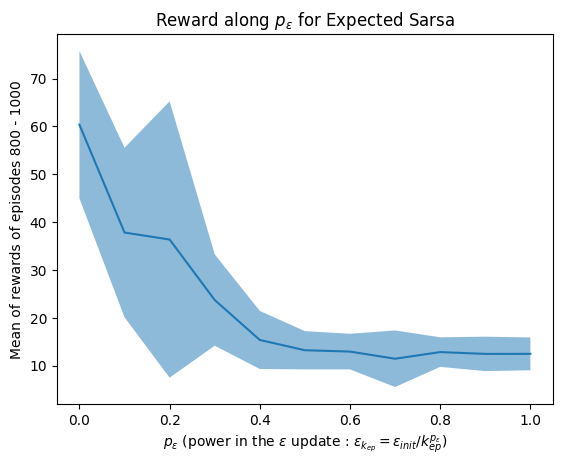

In [31]:
m = mean_rw_eps_law_sarsa.mean(axis=1)
s = mean_rw_eps_law_sarsa.std(axis=1)
plt.plot(eps_law_list_sarsa, m)
plt.fill_between(eps_law_list_sarsa, m - s, m + s, alpha=0.5)
plt.xlabel("$p_\\epsilon$ (power in the $\\epsilon$ update : $\\epsilon_{k_{ep}} = \\epsilon_{init}/k_{ep}^{p_\\epsilon}$)")
plt.ylabel("Mean of rewards of episodes 800 - 1000")
plt.title("Reward along $p_\\epsilon$ for Expected Sarsa")
plt.show()

# State value function

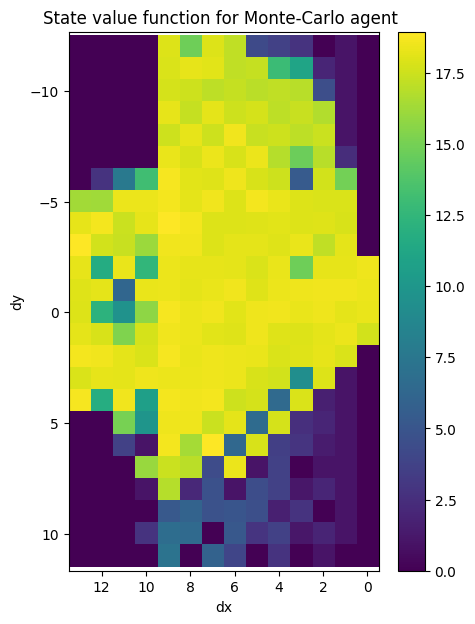

In [39]:
plt.figure(figsize=(5, 7))
vf_reshaped = ag_mc.get_state_value_function()
plt.pcolor(np.arange(14), np.arange(-12, 12), vf_reshaped)
# plt.imshow(vf_reshaped)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylabel("dy")
plt.xlabel("dx")
plt.axis("equal")
plt.title("State value function for Monte-Carlo agent ")
plt.colorbar()
plt.show()

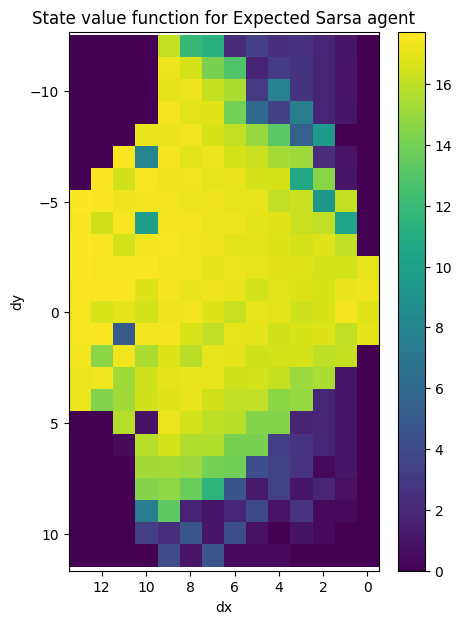

In [40]:
plt.figure(figsize=(5, 7))
vf_reshaped = ag_sar.get_state_value_function()
plt.pcolor(np.arange(14), np.arange(-12, 12), vf_reshaped)
# plt.imshow(vf_reshaped)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylabel("dy")
plt.xlabel("dx")
plt.axis("equal")
plt.title("State value function for Expected Sarsa agent")
plt.colorbar()
plt.show()